<a href="https://colab.research.google.com/github/falseywinchnet/PicoGPT/blob/main/NewGPT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
#copyright joshuah.rainstar@gmail.com 2025
#MIT with attribution

import math
import copy
from dataclasses import dataclass
from typing import Optional, Tuple, List

import torch
import torch.nn as nn
import torch.nn.functional as F

class RoPE(nn.Module):
    """Rotary Positional Embeddings."""
    def __init__(self, dim, max_len=4096):
        super().__init__()
        self.dim = dim
        inv_freq = 1.0 / (10000 ** (torch.arange(0, dim, 2).float() / dim))
        t = torch.arange(max_len).float()
        freqs = torch.einsum('i,j->ij', t, inv_freq)
        self.register_buffer('cos', freqs.cos())
        self.register_buffer('sin', freqs.sin())

    def forward(self, x):
        # x: (B, H, T, D)
        seq_len = x.shape[2]
        cos = self.cos[:seq_len, :].unsqueeze(0).unsqueeze(0)
        sin = self.sin[:seq_len, :].unsqueeze(0).unsqueeze(0)
        x1 = x[..., 0::2]
        x2 = x[..., 1::2]
        return torch.cat((-x2 * sin + x1 * cos, x1 * sin + x2 * cos), dim=-1)

class ConvexSoftmax(nn.Module):
    """Convex LSE (Float32 Precision)."""
    def forward(self, scores):
        m, _ = scores.max(dim=-1, keepdim=True)
        y = scores - m
        ex = y.exp()
        lse = m + ex.sum(dim=-1, keepdim=True).log()
        return torch.exp(scores - lse)

class BiasedWedge(nn.Module):
    """
    Symplectic Geometry with an Escape Hatch.
    S = (A - A^T) + D
    """
    def __init__(self, head_dim, total_heads):
        super().__init__()
        self.head_dim = head_dim
        self.total_heads = total_heads

        # 1. Shared Skew (Global Twist): (D, D)
        self.A = nn.Parameter(torch.zeros(head_dim, head_dim))

        # 2. Identity Bias (Local Preservation): (TotalHeads, D)
        self.id_bias = nn.Parameter(torch.zeros(total_heads, head_dim))

    def forward(self, x):
        # x: (B, TotalHeads, T, D)

        # Construct S
        skew = self.A - self.A.transpose(-1, -2) # (D, D)
        diag = torch.diag_embed(self.id_bias)      # (H, D, D)
        S = skew + diag # Broadcasts to (H, D, D)

        # Apply Flow: x @ S
        # USE EINSUM TO PREVENT BROADCASTING ERRORS
        # b: Batch
        # h: TotalHeads (Matches S dim 0)
        # t: Time (Ignored by S)
        # d: Input Dim (Contracted)
        # e: Output Dim
        flow = torch.einsum('bhtd,hde->bhte', x, S)

        return x + flow

class Attention(nn.Module):
    def __init__(self, d_model, n_head,W_V):
        super().__init__()
        self.d_model = d_model
        self.W_V=W_V
        # System Hierarchy
        self.n_branches = n_head
        self.head_dim = 64
        self.n_sub_heads = d_model // self.head_dim
        assert d_model % self.head_dim == 0, "d_model must be divisible by head_dim"

        # Unified Head Dimension
        self.n_total_heads = self.n_branches * self.n_sub_heads

        self.scale = self.head_dim ** -0.5

        # --- 1. Projections ---
        self.W_K = nn.Linear(d_model, d_model, bias=True)
        self.W_Q_all = nn.Linear(d_model, d_model * self.n_branches, bias=False)
        self.W_V = nn.Linear(d_model, d_model, bias=True)

        # --- 2. Geometry ---
        # Ensure we use the BiasedWedge with einsum
        self.wedge = BiasedWedge(self.head_dim, self.n_total_heads)
        self.rope = RoPE(self.head_dim)

        # --- 3. Sink Parameters ---
        self.sink_scalars = nn.Parameter(torch.zeros(self.n_total_heads, 1, 1))
        self.v_nulls = nn.Parameter(torch.zeros(self.n_branches, d_model))

        # --- 4. Output ---
        self.W_O_params = nn.Parameter(torch.empty(self.n_branches, d_model, d_model))
        self.W_O_bias = nn.Parameter(torch.zeros(self.n_branches, d_model))

        nn.init.xavier_uniform_(self.W_O_params)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        B, T, C = x.shape
        H_tot = self.n_total_heads
        N_br = self.n_branches
        N_sh = self.n_sub_heads
        Dh = self.head_dim

        # 1. Projections
        # Q: (B, T, TotalHeads, Dh) -> (B, TotalHeads, T, Dh)
        q = self.W_Q_all(x).view(B, T, H_tot, Dh).permute(0, 2, 1, 3)

        # K: (B, T, SubHeads, Dh) -> Expand to TotalHeads
        k_base = self.W_K(x).view(B, T, N_sh, Dh).permute(0, 2, 1, 3)
        k = k_base.repeat(1, N_br, 1, 1)

        # V: Expand to TotalHeads
        v_base = self.W_V(x).view(B, T, N_sh, Dh).permute(0, 2, 1, 3)
        v = v_base.repeat(1, N_br, 1, 1)

        # 2. Geometry
        q = self.wedge(q)
        k = self.wedge(k)

        q = self.rope(q)
        k = self.rope(k)

        # 3. Attention
        attn_scores = (q @ k.transpose(-2, -1)) * self.scale
        mask = torch.triu(torch.ones(T, T, device=x.device), diagonal=1).bool()
        attn_scores.masked_fill_(mask, float('-inf'))

        # Sinks
        sinks = self.sink_scalars.view(1, H_tot, 1, 1).expand(B, -1, T, -1)
        attn_scores_full = torch.cat([attn_scores, sinks], dim=-1)
        probs_full = self.softmax(attn_scores_full)

        # 4. Value Aggregation
        probs_tokens = probs_full[..., :T]
        probs_sink   = probs_full[..., T:]

        out_tokens = probs_tokens @ v

        # Sinks (Reshape v_nulls to broadcast correctly)
        # v_nulls: (Br, D) -> (Br*Sh, Dh) -> (1, H_tot, 1, Dh)
        v_null_expanded = self.v_nulls.view(N_br * N_sh, Dh).view(1, H_tot, 1, Dh)
        out_sinks = probs_sink * v_null_expanded

        context = out_tokens + out_sinks # (B, H_tot, T, Dh)

        # 5. Output
        # Recover Branch dim
        context = context.view(B, N_br, N_sh, T, Dh)
        context = context.permute(0, 1, 3, 2, 4).contiguous().view(B, N_br, T, C)

        # Projection & Bias (Explicit broadcast fix for Bias)
        y_proj = torch.einsum('bntc,ncd->bntd', context, self.W_O_params)
        bias = self.W_O_bias.view(1, N_br, 1, C)

        y = y_proj + bias

        return y.mean(dim=1)


class LayerNorm(nn.Module):
    def __init__(self, ndim: int, bias: bool = True):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(ndim))
        self.use_bias = bias
        if bias:
            self.bias = nn.Parameter(torch.zeros(ndim))
        else:
            self.register_parameter("bias", None)
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        b = self.bias if self.use_bias else None
        return F.layer_norm(x, self.weight.shape, self.weight, b, 1e-5)

class MLP(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.c_fc    = nn.Linear( config.n_embd,4* config.n_embd, bias=config.bias)
        self.scale = math.pi / math.sqrt(3.0)

        self.c_proj  = nn.Linear(4 * config.n_embd, config.n_embd, bias=config.bias)
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, x):
        x = self.c_fc(x)
        x = x * torch.sigmoid(self.scale * x)
        x = self.c_proj(x)
        x = self.dropout(x)
        return x

class Block(nn.Module):
    def __init__(self, config,W_V):
        super().__init__()
        self.ln_1 = LayerNorm(config.n_embd, bias=config.bias)
        self.attn = Attention(config.n_embd,config.n_head,W_V)
        self.ln_2 = LayerNorm(config.n_embd, bias=config.bias)
        self.mlp = MLP(config)

    def forward(self,x):
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x

import torch.utils.checkpoint as checkpoint # New: Required for activation checkpointing
@dataclass
class GPTConfig:
    block_size: int = 1024
    vocab_size: int = 50304 # GPT-2 vocab_size of 50257, padded up to nearest multiple of 64 for efficiency
    n_layer: int = 12
    n_head: int = 12
    n_embd: int = 768
    dropout: float = 0.0
    bias: bool = True # True: bias in Linears and LayerNorms, like GPT-2. False: a bit better and faster

class GPT(nn.Module):

    def __init__(self, config):
        super().__init__()
        assert config.vocab_size is not None
        assert config.block_size is not None
        self.config = config
        self.W_V= nn.Linear(config.n_embd, config.n_embd, bias=True),

        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.n_embd),
            drop = nn.Dropout(config.dropout),
            h = nn.ModuleList([Block(config,self.W_V) for _ in range(config.n_layer)]),
            ln_f = LayerNorm(config.n_embd, bias=config.bias),
        ))

        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)
        # report number of parameters
        print("number of parameters: %.2fM" % (self.get_num_params()/1e6,))

    def get_num_params(self, non_embedding=True):
        """
        Return the number of parameters in the model.
        For non-embedding count (default), the position embeddings get subtracted.
        The token embeddings would too, except due to the parameter sharing these
        params are actually used as weights in the final layer, so we include them.
        """
        n_params = sum(p.numel() for p in self.parameters())
        return n_params

    def forward(self, idx, targets=None):
        device = idx.device
        b, T = idx.size()

        # forward the GPT model itself
        x = self.transformer.wte(idx) # token embeddings of shape (b, t, n_embd)
        for block in self.transformer.h:
            x  = checkpoint.checkpoint(block, x, use_reentrant=False)

        x = self.transformer.ln_f(x)

        if targets is not None:
            # if we are given some desired targets also calculate the loss
            logits = self.lm_head(x)

            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)

        else:
            # inference-time mini-optimization: only forward the lm_head on the very last position
            logits = self.lm_head(x[:, [-1], :]) # note: using list [-1] to preserve the time dim
            loss = None

        return logits, loss


In [2]:
import requests, os

base_url = "https://huggingface.co/datasets/cambridge-climb/BabyLM/resolve/main/clean/10M/"
target_dir = "./babylm_10m_cleaned"
os.makedirs(target_dir, exist_ok=True)

file_names = [
    "aochildes.txt",
    "cbt.txt",
    "children_stories.txt",
    "gutenberg.txt",
    "qed.txt",
    "simple_wikipedia.txt",
    "switchboard.txt",
    "wikipedia.txt"
]

# Optional addition: Shakespeare from another dataset
shakespeare_url = "https://raw.githubusercontent.com/karpathy/char-rnn/refs/heads/master/data/tinyshakespeare/input.txt"
shakespeare_fname = "shakespeare.txt"

# Combined download logic
all_files = [(base_url + fname, fname) for fname in file_names]
all_files.append((shakespeare_url, shakespeare_fname))  # Add Shakespeare


# Download loop
for url, fname in all_files:
    out_path = os.path.join(target_dir, fname)
    print(f"📥 Downloading {fname}...")
    resp = requests.get(url)
    if resp.status_code == 200:
        with open(out_path, "w", encoding="utf-8") as f:
            f.write(resp.text)
    else:
        print(f"❌ Failed to download {fname} ({resp.status_code})")

print(f"✅ Done. Files saved to {target_dir}")

📥 Downloading aochildes.txt...
📥 Downloading cbt.txt...
📥 Downloading children_stories.txt...
📥 Downloading gutenberg.txt...
📥 Downloading qed.txt...
📥 Downloading simple_wikipedia.txt...
📥 Downloading switchboard.txt...
📥 Downloading wikipedia.txt...
📥 Downloading shakespeare.txt...
✅ Done. Files saved to ./babylm_10m_cleaned


In [1]:
import os
import pickle
import numpy as np

# === Paths ===
source_dir = "./babylm_10m_cleaned"
out_dir    = "./babylm_char_tokenized"
os.makedirs(out_dir, exist_ok=True)

file_names = [
    "shakespeare.txt","aochildes.txt", "cbt.txt", "children_stories.txt", "gutenberg.txt",
    "qed.txt", "simple_wikipedia.txt", "switchboard.txt", "wikipedia.txt"
]

# === Load and split ===
train_texts, val_texts = [], []
char_set = set()

for fname in file_names:
    with open(os.path.join(source_dir, fname), encoding="utf-8") as f:
        lines = f.readlines()
        n = len(lines)
        split = int(0.9 * n)
        train_part = "".join(lines[:split])
        val_part   = "".join(lines[split:])
        train_texts.append(train_part)
        val_texts.append(val_part)
        char_set.update(train_part)
        char_set.update(val_part)

full_train = "\n".join(train_texts)
full_val   = "\n".join(val_texts)

# === Final vocab ===
char_set = sorted(set(char_set))
vocab_chars = ["<unk>"] + [c for c in char_set if c != "<unk>"]

stoi = {ch: i for i, ch in enumerate(vocab_chars)}
itos = {i: ch for ch, i in stoi.items()}

# === Encode function ===
def encode(text):
    return [stoi.get(c, 0) for c in text]

train_ids = np.array(encode(full_train), dtype=np.uint16)
val_ids   = np.array(encode(full_val),   dtype=np.uint16)

# === Save ===
train_ids.tofile(os.path.join(out_dir, "train.bin"))
val_ids.tofile(os.path.join(out_dir, "val.bin"))

with open(os.path.join(out_dir, "meta.pkl"), "wb") as f:
    pickle.dump({
        "vocab_size": len(stoi),
        "stoi": stoi,
        "itos": itos
    }, f)

print(f"✅ Char tokenizer finalized.")
print(f"🧾 Train tokens: {len(train_ids)} | Val tokens: {len(val_ids)}")
print(f"🔤 Vocab size: {len(stoi)}")

✅ Char tokenizer finalized.
🧾 Train tokens: 29893208 | Val tokens: 2902581
🔤 Vocab size: 1437


In [4]:
# import os
import pickle
import numpy as np
from torch.utils.data import DataLoader, Dataset
import torch
from torch import nn
import torch.nn.functional as F

device = "cuda" if torch.cuda.is_available() else "cpu"

# === Config ===
data_dir = "./babylm_char_tokenized"  # <- char-tokenized data
block_size = 1024
batch_size = 16

# === Load tokenizer metadata ===
with open(os.path.join(data_dir, 'meta.pkl'), 'rb') as f:
    meta = pickle.load(f)
vocab_size = meta['vocab_size']

# === Load mmap edata (char-level tokens, uint16) ===
train_ids = np.memmap(os.path.join(data_dir, 'train.bin'), dtype=np.uint16, mode='r')
val_ids   = np.memmap(os.path.join(data_dir, 'val.bin'),   dtype=np.uint16, mode='r')

# === Efficient GPU Batch Sampler ===
class GPUBatchDataset(Dataset):
    def __init__(self, mmap_file, block_size, batch_size, device, jitter=63, p_aligned=0.5, pad_len=0):
        self.data = mmap_file
        self.block_size = block_size
        self.batch_size = batch_size
        self.device = device
        self.pad_len = int(pad_len)
        self.sample_len = self.block_size + self.pad_len  # X length
        self.total = len(self.data) - self.sample_len - 1
        self.n_blocks = self.total // self.sample_len
        self.jitter = int(jitter)          # small random offset added to aligned start
        self.p_aligned = float(p_aligned)  # mix aligned and jittered

    def __len__(self):
        return self.total // self.batch_size

    def __getitem__(self, idx):
        X = np.empty((self.batch_size, self.sample_len), dtype=np.int64)
        Y = np.empty((self.batch_size, self.block_size), dtype=np.int64)

        for i in range(self.batch_size):
            # choose a base aligned block
            base_block = np.random.randint(0, self.n_blocks)
            start = base_block * self.sample_len

            # with probability, add a small jitter (keeps cache-friendly contiguous reads)
            if np.random.rand() > self.p_aligned:
                j = np.random.randint(0, self.jitter + 1)
                start = min(start + j, self.total)  # stay in range

            X[i] = self.data[start : start + self.sample_len]
            # targets correspond to the final block_size visible steps
            Y[i] = self.data[start + 1 + self.pad_len : start + 1 + self.pad_len + self.block_size]


        return (
            torch.from_numpy(X).to(self.device, non_blocking=True),
            torch.from_numpy(Y).to(self.device, non_blocking=True)
        )


config = GPTConfig(
    vocab_size=len(stoi),
    n_layer=6,
    n_embd=256,
    n_head =4,
    block_size=block_size
)
train_dataset = GPUBatchDataset(train_ids, block_size, batch_size, device, pad_len=0)
# === DataLoader ===
train_loader  = DataLoader(train_dataset, batch_size=1, shuffle=False, num_workers=0)
model = GPT(config)
#model = torch.compile(model)
model = model.to(device)



number of parameters: 7.87M


```
11/27/25
joshs notes at 4 fucking am

next steps for design:
get per-head sink activation statistics
use to select expert- 1 per head- in moe of block
use hard routed or soft routed, prolly doesnt matter

The Q-star mechanism:
Replace CEloss with a system which collects markov/red/green continuations
takes targets and builds logit distributions of likely continuations
evolves over time to represent all possible forecasts at T in probability
and which uses a peaking student-t reshaping deeper into model
to condition the model to become a beam search system
ie model out-projects to logits using lm_head at each layer,
we take mismatch as aux loss, we accumulate aux and return as loss

softmax is garbage in terms of manifold deterministic intelligence, but then,
how do we make next choices? we need the next position target that represents
the models confidence as a distribution. here too q-star picks next step.
or something


```

In [5]:
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-3)
losses = []
def train_epoch():
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
          xb, yb = xb[0], yb[0]  # unwrap batch dimension
          optimizer.zero_grad()
          logits, loss = model(xb, yb)
          loss = loss
          loss.backward()
          torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
          optimizer.step()
          total_loss += loss.item()
          losses.append(loss.item())
          print(loss.item())
    return total_loss / len(train_loader)

# === Run Training ===
num_epochs = 10
for epoch in range(1, num_epochs + 1):
    train_loss = train_epoch()
    print(f"Epoch {epoch:2d} | Train loss: {train_loss:.4f}")

7.356609344482422
5.154809951782227
4.567403316497803
3.83613920211792
3.520630359649658
3.0506136417388916
2.9501569271087646
2.838278293609619
2.6645336151123047
2.7028064727783203
2.719552755355835
2.6089324951171875
2.6016018390655518
2.639352560043335
2.585036277770996
2.611063003540039
2.5182435512542725
2.602964401245117
2.578279733657837
2.5847272872924805
2.557373523712158
2.55056095123291
2.5758605003356934
2.4934585094451904
2.665297031402588
2.627162456512451
2.5183935165405273
2.490431308746338
2.520662784576416
2.5366063117980957
2.4712421894073486
2.455122470855713
2.5327892303466797
2.4396533966064453
2.4455199241638184
2.496511936187744
2.4682207107543945
2.432371139526367
2.472313404083252
2.420626163482666
2.437983274459839
2.4488232135772705
2.466218948364258
2.48982834815979
2.422070026397705
2.3746283054351807
2.364198923110962
2.386336088180542
2.342262029647827
2.3245420455932617
2.298825263977051
2.337001323699951
2.2938170433044434
2.3284354209899902
2.3074498

KeyboardInterrupt: 

In [ ]:
# === Run Training ===
num_epochs = 10
for epoch in range(1, num_epochs + 1):
    train_loss = train_epoch()
    print(f"Epoch {epoch:2d} | Train loss: {train_loss:.4f}")

1.4566658735275269
1.5080339908599854
1.5089287757873535
1.460397720336914
1.5198886394500732
1.4255211353302002
1.4719089269638062
1.4782851934432983
1.4679419994354248
1.4554510116577148
1.4538438320159912
1.448591947555542
1.4431008100509644
1.416642189025879
1.472662091255188
1.433960199356079
1.4927616119384766
1.4703067541122437
1.4890273809432983
1.4805957078933716
1.455891489982605
1.4444636106491089
1.4307796955108643
1.4706676006317139
1.4754023551940918
1.426900863647461
1.5055663585662842
1.4736088514328003
1.4874308109283447
1.4173120260238647
1.4170727729797363
1.4442713260650635
1.4225490093231201
1.4070971012115479
1.4256688356399536
1.4435036182403564
1.4271667003631592
1.4367170333862305
1.4285753965377808
1.435206651687622
1.4284183979034424
1.442136526107788
1.4068565368652344
1.452209234237671
1.4324004650115967
1.4561877250671387
1.3871681690216064
1.4385766983032227
1.442659854888916
1.4693256616592407
1.3894028663635254
1.4519269466400146
1.4508363008499146
1.41

KeyboardInterrupt: 

Visualizing activations for the last window of generated text...


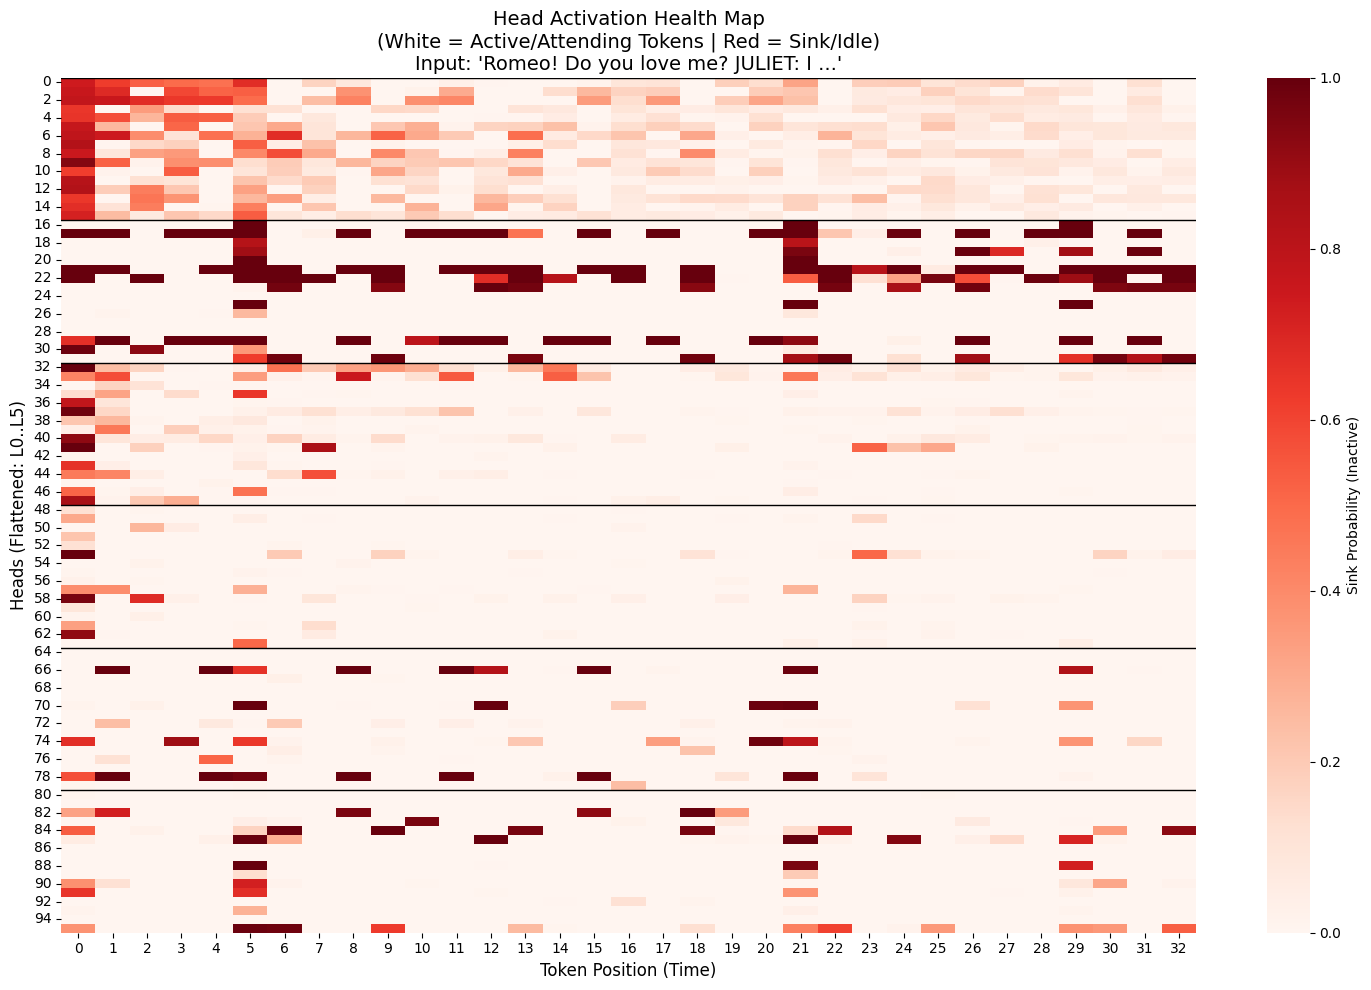

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import seaborn as sns

class AttentionAnalyzer:
    """
    Hooks into the GPT model to capture Softmax probabilities.
    """
    def __init__(self, model):
        self.model = model
        self.hooks = []
        # Store: {layer_idx: tensor of shape (B, TotalHeads, T, T+1)}
        self.attn_probs = {}

    def _get_hook(self, layer_idx):
        def hook(module, input, output):
            # output is the result of Softmax(scores)
            # Shape: (B, TotalHeads, T, T_ctx + 1) -> The +1 is the Sink
            # We detach and move to CPU immediately to save GPU memory
            self.attn_probs[layer_idx] = output.detach().cpu()
        return hook

    def attach(self):
        """Register hooks on the softmax layer of each block."""
        self.hooks = []
        self.attn_probs = {}
        for i, block in enumerate(self.model.transformer.h):
            # We hook the softmax module directly
            h = block.attn.softmax.register_forward_hook(self._get_hook(i))
            self.hooks.append(h)

    def detach(self):
        """Remove all hooks."""
        for h in self.hooks:
            h.remove()
        self.hooks = []

def visualize_head_activity(model, text, stoi, block_size=1024, figsize=(15, 10)):
    """
    Runs the text through the model and visualizes:
    1. Sink Probability Map (How often heads 'bail out')
    """
    # 1. Prepare Data
    device = next(model.parameters()).device
    ids = [stoi.get(c, 0) for c in text]

    # Crop to block_size if needed, otherwise we get size mismatch errors
    if len(ids) > block_size:
        print(f"Text length {len(ids)} > block_size {block_size}. Cropping to last {block_size} chars.")
        ids = ids[-block_size:]
        text_display = text[-block_size:]
    else:
        text_display = text

    x = torch.tensor([ids], dtype=torch.long, device=device)

    # 2. Run with Hooks
    analyzer = AttentionAnalyzer(model)
    analyzer.attach()

    model.eval()
    with torch.no_grad():
        # We don't care about logits, just the hooks firing
        model(x)

    analyzer.detach()

    # 3. Process Data: Extract Sink Probabilities
    # We want a matrix: [All_Heads_Across_Layers, Sequence_Length]
    # Value = Probability of attending to Sink (0.0 = Busy, 1.0 = Idle)

    layers = sorted(analyzer.attn_probs.keys())
    n_layers = len(layers)

    # Check shape from first layer
    # probs: (B, TotalHeads, T, T+1)
    B, H_tot, T, _ = analyzer.attn_probs[0].shape

    # Prepare the heatmap matrix
    # Rows = Layers * TotalHeads
    sink_map = np.zeros((n_layers * H_tot, T))

    for i in layers:
        probs = analyzer.attn_probs[i] # (1, H, T, T+1)
        # The sink is the LAST element in the last dimension (-1)
        sink_probs = probs[0, :, :, -1] # (H, T)

        row_start = i * H_tot
        row_end = (i + 1) * H_tot
        sink_map[row_start:row_end, :] = sink_probs.numpy()

    # 4. Plotting
    plt.figure(figsize=figsize)

    # We use a diverging colormap or simply 'Reds'
    # Low Value (White) = Looking at Tokens (Active)
    # High Value (Red) = Looking at Sink (Inactive/Bailed out)
    ax = sns.heatmap(sink_map, cmap="Reds", vmin=0, vmax=1, cbar_kws={'label': 'Sink Probability (Inactive)'})

    ax.set_title(f"Head Activation Health Map\n(White = Active/Attending Tokens | Red = Sink/Idle)\nInput: '{text_display[:50]}...'", fontsize=14)
    ax.set_xlabel("Token Position (Time)", fontsize=12)
    ax.set_ylabel(f"Heads (Flattened: L0..L{n_layers-1})", fontsize=12)

    # Add Layer dividers
    for i in range(n_layers):
        plt.axhline(i * H_tot, color='black', linewidth=1)

    plt.tight_layout()
    plt.show()

    return analyzer

# --- Execution ---
# Assumes 'generated' contains the string from your previous step
print("Visualizing activations for the last window of generated text...")
analyzer = visualize_head_activity(model, "Romeo! Do you love me? JULIET: I ", stoi, block_size=model.config.block_size)

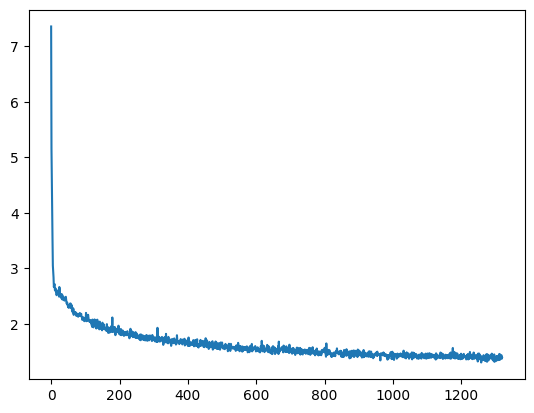

In [7]:
from matplotlib import pyplot as plt
plt.plot(losses)
plt.show()

In [8]:
import numpy as np
import torch
import torch.nn.functional as F

@torch.no_grad()
def eval_bits_per_char(model, val_ids, block_size=1024, max_batches=200, device=None):
    """
    Computes BPC and PPL on random contiguous slices.
    Assumes ?1 the loss returned by model(x, y) is mean NLL per token.
    """
    model.eval()
    if device is None:
        device = next(model.parameters()).device

    total_nll_nat = 0.0
    total_tokens = 0

    for _ in range(max_batches):
        if len(val_ids) <= block_size + 1:
            break

        start = np.random.randint(0, len(val_ids) - block_size - 1)
        x = torch.tensor(val_ids[start:start+block_size], dtype=torch.long, device=device)[None, :]
        y = torch.tensor(val_ids[start+1:start+block_size+1], dtype=torch.long, device=device)[None, :]

        # IMPORTANT: pass y so the model returns a sequence loss
        logits, loss = model(x, y)

        # If model doesn’t return loss for some reason, compute it safely
        if loss is None:
            # Handle both possible logits shapes
            if logits.dim() == 3 and logits.size(1) == x.size(1):
                # full sequence logits [B, T, V]
                B, T, V = logits.shape
                ce = F.cross_entropy(logits.view(-1, V), y.view(-1), reduction="mean")
                nll_nat = ce.item()
                tokens = T * B
            elif logits.dim() == 2:
                # last-step logits [B, V] -> only evaluate the last target
                ce = F.cross_entropy(logits, y[:, -1], reduction="mean")
                nll_nat = ce.item()
                tokens = logits.size(0)  # B tokens (here 1)
            else:
                raise ValueError(f"Unexpected logits shape: {tuple(logits.shape)}")
        else:
            # ?1 assume this is mean NLL per token (standard)
            nll_nat = float(loss.item())
            tokens = x.numel()  # B * T

        total_nll_nat += nll_nat * tokens
        total_tokens  += tokens

    if total_tokens == 0:
        return float("nan"), float("nan")

    avg_nll_nat = total_nll_nat / total_tokens
    bpc = avg_nll_nat / np.log(2.0)
    ppl = float(np.exp(avg_nll_nat))
    return bpc, ppl

bpc, ppl = eval_bits_per_char(model, val_ids, block_size=1024, max_batches=200, device=device)
print("BPC:", bpc, "Perplexity:", ppl)


BPC: 2.082174663991947 Perplexity: 4.234450204265966


'''
Negative log-likelihood (NLL): The metric underneath both BPC and PPL is the average negative log probability assigned to the true next token. Lower NLL means the model is assigning higher probability to correct targets → better performance.

BPC = NLL in bits per token. Lower BPC means fewer bits are needed to encode the text, i.e. the model compresses language better. A perfect model would reach 0.0 BPC.

PPL = exp(NLL). It represents the "effective branching factor" (how many equally likely next tokens the model is as uncertain between). Lower perplexity means the model is more confident and accurate. A perfect model would reach 1.0 PPL.
Models with <100k parameters usually collapse to gibberish or never beat 5-gram.
BPC of NGRAM is ~3.5-4
'''

In [9]:
import pickle
def decode_chars(token_ids, itos):
    """
    Decodes a list of character token IDs into a string.
    """
    return ''.join([itos[i] for i in token_ids])

def encode_chars(text, stoi):
    """
    Encodes a string into a list of token IDs, one per character.
    """
    return [stoi.get(c, 0) for c in text]


import torch

def decode_sequence_char(
    model, stoi, itos, prompt, max_new_tokens=100, block_size=256,
    use_fenchel=False, tau=1.0, fenchel_iters=3, temperature=1.0
):
    model.eval()
    device = next(model.parameters()).device

    max_ctx = int(block_size)

    # ?1 pad token: try space, fallback to 0
    space_id = stoi.get(' ', 0)

    # encode prompt
    start_ids = torch.tensor([encode_chars(prompt, stoi)], dtype=torch.long, device=device)

    # If prompt is longer than block, keep the last block_size chars
    if start_ids.size(1) > max_ctx:
        start_ids = start_ids[:, -max_ctx:]

    # Left-pad to exactly block_size so the first pass sees a full window
    pad_len = max(0, max_ctx - start_ids.size(1))
    if pad_len > 0:
        pad = torch.full((1, pad_len), space_id, dtype=torch.long, device=device)
        idx = torch.cat([pad, start_ids], dim=1)  # shape [1, block_size]
    else:
        idx = start_ids  # already block_size or longer (truncated above)

    initial_pad_len = pad_len  # for stripping at the end

    # generation loop
    with torch.no_grad():
        for _ in range(max_new_tokens):
            context = idx[:, -max_ctx:]  # always feed the last block_size tokens
            logits, _ = model(context, None)
            last_logits = logits[:, -1, :]
            if temperature != 1.0:
                last_logits = last_logits / float(temperature)
            probs = torch.softmax(last_logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)  # [1,1]
            idx = torch.cat([idx, next_token], dim=1)

    # drop the initial left-pad when decoding to text
    out_tokens = idx[0, initial_pad_len:].tolist()
    return decode_chars(out_tokens, itos)


with open("./babylm_char_tokenized/meta.pkl", "rb") as f:
    meta = pickle.load(f)
stoi = meta["stoi"]
itos = meta["itos"]

prompt = "ROMEO: Juliet, do you love me?  JULIET:"
generated = decode_sequence_char(
    model=model,
    stoi=stoi,
    itos=itos,
    prompt=prompt,
    max_new_tokens=2048,
    block_size=1024,
    use_fenchel=False,
    tau=1.5,
    fenchel_iters=2,
    temperature=1.0
)

print(generated)


ROMEO: Juliet, do you love me?  JULIET: The ancent us got their chocolor:
I lie, my nervihual
medith to another of Lanaletan would have notoralyhed. a't letter her on my sweet melts observed you the occurs of the place,
Under young though available and not, night, and my slyst sitting at the hose rest less minno'r book: 'too battlite, those thorough with now and fat doubly,
What was missed about a beauty or society
Thinging,
We'll perform Pular, hot dothfuse,
That put to are years.' Go and call fortwaorfgal,
First too, what happy, he fell, where you. you have heart hays any one
Than love Threw, and i could thou chart alone?
Show when my appeachery was you, for with your business--
O boses as a bboth bodymate's equation of ottousaes, since them, underwell is just as i haven't discontinue that it as good as so great fairy help several depeases?

I will not see.
And the suspiclock?
In a weep of your creates
I not that thou come
For you have sharpely packed up in my courses and insistant s

In [12]:
import pickle
def decode_chars(token_ids, itos):
    """
    Decodes a list of character token IDs into a string.
    """
    return ''.join([itos[i] for i in token_ids])

def encode_chars(text, stoi):
    """
    Encodes a string into a list of token IDs, one per character.
    """
    return [stoi.get(c, 0) for c in text]


import torch

def decode_sequence_char(
    model, stoi, itos, prompt, max_new_tokens=100, block_size=256,
    use_fenchel=False, tau=1.0, fenchel_iters=3, temperature=1.0
):
    model.eval()
    device = next(model.parameters()).device

    max_ctx = int(block_size)

    # ?1 pad token: try space, fallback to 0
    space_id = stoi.get(' ', 0)

    # encode prompt
    start_ids = torch.tensor([encode_chars(prompt, stoi)], dtype=torch.long, device=device)

    # If prompt is longer than block, keep the last block_size chars
    if start_ids.size(1) > max_ctx:
        start_ids = start_ids[:, -max_ctx:]

    # Left-pad to exactly block_size so the first pass sees a full window
    pad_len = max(0, max_ctx - start_ids.size(1))
    if pad_len > 0:
        pad = torch.full((1, pad_len), space_id, dtype=torch.long, device=device)
        idx = torch.cat([pad, start_ids], dim=1)  # shape [1, block_size]
    else:
        idx = start_ids  # already block_size or longer (truncated above)

    initial_pad_len = pad_len  # for stripping at the end

    # generation loop
    with torch.no_grad():
        for _ in range(max_new_tokens):
            context = idx[:, -max_ctx:]  # always feed the last block_size tokens
            logits, _ = model(context, None)
            last_logits = logits[:, -1, :]
            if temperature != 1.0:
                last_logits = last_logits / float(temperature)
            probs = torch.softmax(last_logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)  # [1,1]
            idx = torch.cat([idx, next_token], dim=1)

    # drop the initial left-pad when decoding to text
    out_tokens = idx[0, initial_pad_len:].tolist()
    return decode_chars(out_tokens, itos)


with open("./babylm_char_tokenized/meta.pkl", "rb") as f:
    meta = pickle.load(f)
stoi = meta["stoi"]
itos = meta["itos"]

prompt = "The rivers nile is located in "
generated = decode_sequence_char(
    model=model,
    stoi=stoi,
    itos=itos,
    prompt=prompt,
    max_new_tokens=2048,
    block_size=1024,
    use_fenchel=False,
    tau=1.5,
    fenchel_iters=2,
    temperature=1.0
)

print(generated)


The rivers nile is located in my owns, lynder!
La valcon.
CoMt! 
GLOUMEWANUS:
Frear is so fear, he answered her; you was sorry assistant for one vife; multis at puositry to seek
the and hobsts true he hath break, or in the aside for, by thongue, depressed on whom commits in a part of our vietnams that makey? on the search of soil
Suglifice:
Useals in myself under thy
klifked or firm and their newspapers. I wish for a chieflad mass, holds on sir.
No doing my lord
Come of advy busy heads: hot to your congress show for tones
By his phrivatehold; blow the great pank.'
No, crazy, but snour, blackbeck'd thou work of biting. O thy grade, we do is usually proves on inence,
Cay, pergiins when, having
ARIGBARINS:
What wanted his cows? at that!
What he ruled.
FoRISUS:
KING MERCUTIO: E CamE bull the worthouse. Come only battertness arly's hat sleep
Far symbol of my punits? i had come no fleor, He because they suppose I had it for you his lyry; part, and think that's going by the shelt.
Whant you i

In [13]:
import pickle
def decode_chars(token_ids, itos):
    """
    Decodes a list of character token IDs into a string.
    """
    return ''.join([itos[i] for i in token_ids])

def encode_chars(text, stoi):
    """
    Encodes a string into a list of token IDs, one per character.
    """
    return [stoi.get(c, 0) for c in text]


import torch

def decode_sequence_char(
    model, stoi, itos, prompt, max_new_tokens=100, block_size=256,
    use_fenchel=False, tau=1.0, fenchel_iters=3, temperature=1.0
):
    model.eval()
    device = next(model.parameters()).device

    max_ctx = int(block_size)

    # ?1 pad token: try space, fallback to 0
    space_id = stoi.get(' ', 0)

    # encode prompt
    start_ids = torch.tensor([encode_chars(prompt, stoi)], dtype=torch.long, device=device)

    # If prompt is longer than block, keep the last block_size chars
    if start_ids.size(1) > max_ctx:
        start_ids = start_ids[:, -max_ctx:]

    # Left-pad to exactly block_size so the first pass sees a full window
    pad_len = max(0, max_ctx - start_ids.size(1))
    if pad_len > 0:
        pad = torch.full((1, pad_len), space_id, dtype=torch.long, device=device)
        idx = torch.cat([pad, start_ids], dim=1)  # shape [1, block_size]
    else:
        idx = start_ids  # already block_size or longer (truncated above)

    initial_pad_len = pad_len  # for stripping at the end

    # generation loop
    with torch.no_grad():
        for _ in range(max_new_tokens):
            context = idx[:, -max_ctx:]  # always feed the last block_size tokens
            logits, _ = model(context, None)
            last_logits = logits[:, -1, :]
            if temperature != 1.0:
                last_logits = last_logits / float(temperature)
            probs = torch.softmax(last_logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)  # [1,1]
            idx = torch.cat([idx, next_token], dim=1)

    # drop the initial left-pad when decoding to text
    out_tokens = idx[0, initial_pad_len:].tolist()
    return decode_chars(out_tokens, itos)


with open("./babylm_char_tokenized/meta.pkl", "rb") as f:
    meta = pickle.load(f)
stoi = meta["stoi"]
itos = meta["itos"]

prompt = "Sally and Andy went swimming."
generated = decode_sequence_char(
    model=model,
    stoi=stoi,
    itos=itos,
    prompt=prompt,
    max_new_tokens=2048,
    block_size=1024,
    use_fenchel=False,
    tau=1.5,
    fenchel_iters=2,
    temperature=1.0
)

print(generated)


Sally and Andy went swimming.

AUFLILASTER:
The look, and animy wine, and every pretty friend; do its traveller.
Co-streed in the rememery come
And thing i think
Art come of the visitor!' HASTIO:
So,
All remure come, minings thy close wound might at other mr.
what's wrong above it: here honest is what ever't. My heaven spoor of his man to whom he youth of circles but the prison: 'ulutes have didiful rewres. Eow’s communist: who, event of his head, that would not that preceds of the sons, and so we didn't beginning with my first a fair planication is in symbol: once have "a chieflars?"
yet as my lieutenant star—dreamless was imagine and eagler i, and if you was amoned; you know, and more. why, tigered alriams ball, we gate she had a word in subsacs nevertheliesly, come into are, long of summonistens, on having busier:
I bear you, we had not In ma riserly; me that come done, and thou sort of the los need.
I surprisons our flyings were bright; good in only have of primitive football
Anacl

In [ ]:
torch.save(model.state_dict(), "model.pt")


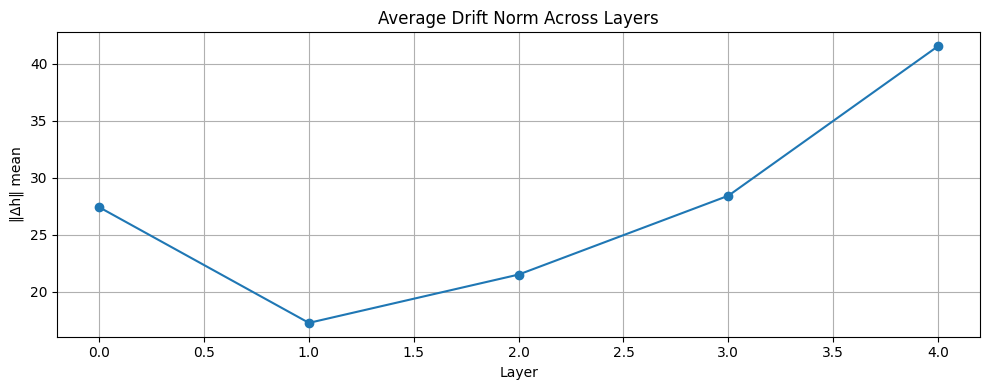

Jacobian rank (final token, projected): 252


In [14]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import grad
'''
     def forward(self, idx, targets=None):
        device = idx.device
        b, T = idx.size()

        # forward the GPT model itself
        x = self.transformer.wte(idx) # token embeddings of shape (b, t, n_embd)

        for block in self.transformer.h:
            x = block(x)
        x = self.transformer.ln_f(x)

        if targets is not None:
            # if we are given some desired targets also calculate the loss
            logits = self.lm_head(x)

            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)

        else:
            # inference-time mini-optimization: only forward the lm_head on the very last position
            logits = self.lm_head(x[:, [-1], :]) # note: using list [-1] to preserve the time dim
            loss = None

        return logits, loss

'''


@torch.no_grad()
def compute_drift_trajectories(model, idx, pad_token_id=None):
    """
    Drift vectors Δh_l = h_{l+1} - h_l aligned to the shrinking time axis.
    idx: [B, T_visible]
    pad_token_id: pad token id to prepend once (?1 default=0 if None)
    returns: list of arrays, one per layer-gap, each shaped [B]
    """
    model.eval()
    device = idx.device
    B, T_vis = idx.size()

    tok = idx
    # forward the GPT model itself


    # token + pos emb
    x = model.transformer.wte(tok)
    layers = []
    with torch.no_grad():
        for block in model.transformer.h:
            x = block(x)             # time shrinks by n_head each block (per your setup)
            layers.append(x.clone()) # store aligned outputs

    # compute drifts with alignment: previous tail matches current length
    drifts = []
    for i in range(len(layers) - 1):
        a = layers[i]
        b = layers[i + 1]
        a_aligned = a[:, -b.size(1):, :]
        d = (b - a_aligned)
        drifts.append(d.norm(dim=-1).mean(dim=-1).cpu().numpy())  # [B]
    return drifts


def compute_jacobian_rank(model, idx, projection_dim=324, pad_token_id=None):
    """
    Rank of Jacobian d logits_proj(T_final) / d emb(T_input_last) with pad-once and shrink.
    idx: [B, T_visible]
    pad_token_id: pad token id to prepend once (?2 default=0 if None)
    """
    model.eval()
    device = idx.device
    B, T_vis = idx.size()

    tok = idx

    # embeddings with grad
    tok_emb = model.transformer.wte(tok)
    emb = tok_emb
    def forward_emb(x):
        for block in model.transformer.h:
            x = block(x)             # time shrinks each block
        x = model.transformer.ln_f(x)
        logits = model.lm_head(x)    # [B, T_out, V]
        return logits[:, -1, :projection_dim]  # final token after shrink, projected

    output = forward_emb(emb)         # [B, P]
    jac_rows = []
    for i in range(output.shape[-1]):
        go = torch.zeros_like(output)
        go[:, i] = 1.0
        gi = grad(output, emb, grad_outputs=go, retain_graph=True)[0]  # [B, T_all, C]
        jac_rows.append(gi[:, -1, :].detach().cpu().numpy().squeeze()) # grad w.r.t. last input step
    J = np.stack(jac_rows, axis=0)     # [P, C]
    return int(np.linalg.matrix_rank(J))

def plot_drift(drift_norms):
    """
    Plot average drift norm per layer.
    """
    plt.figure(figsize=(10, 4))
    plt.plot([np.mean(d) for d in drift_norms], marker='o')
    plt.title("Average Drift Norm Across Layers")
    plt.xlabel("Layer")
    plt.ylabel("‖Δh‖ mean")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Example usage
input_ids = torch.randint(0, model.config.vocab_size, (1, model.config.block_size)).to(device)

jac_rank = compute_jacobian_rank(model, input_ids)

drift_norms = compute_drift_trajectories(model, input_ids)
plot_drift(drift_norms)

print("Jacobian rank (final token, projected):", jac_rank)


In [15]:
import torch
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def collect_drift_matrix(model, idx, pad_token_id=None):
    """
    Build a drift matrix by stacking aligned per-layer deltas:
      Δ_l = h_{l+1} - tail_match(h_l)
    Tail-match aligns time since each block trims from the left.

    idx: [B, T_visible]
    pad_token_id: ?1 left-pad token id; default 0 if None
    returns: torch.FloatTensor [N, D] on CPU where N = sum_l B * T_l
    """
    model.eval()
    device = idx.device
    B, T_vis = idx.size()

    tok = idx

    # 2) embed like forward() does
    x = model.transformer.wte(tok)
    # 3) collect per-block states (time shrinks each block)
    states = []
    with torch.no_grad():
        for block in model.transformer.h:
            x = block(x)     # length shrinks by your per-layer trim
            states.append(x.clone())

    # 4) aligned drifts: match tail of h_l to h_{l+1}
    drift_chunks = []
    for i in range(len(states) - 1):
        a = states[i]       # [B, T_a, C]
        b = states[i + 1]   # [B, T_b, C], T_b <= T_a
        a_aligned = a[:, -b.size(1):, :]     # tail-match
        d = (b - a_aligned).reshape(-1, b.size(-1))  # [B*T_b, C]
        drift_chunks.append(d.cpu())

    drift_matrix = torch.cat(drift_chunks, dim=0) if drift_chunks else torch.empty(0, tok_emb.size(-1))
    return drift_matrix  # [N, D] on CPU


def run_drift_pca(drift_matrix, k=40):
    """
    PCA on drift samples. drift_matrix can be torch.Tensor [N, D] (CPU or CUDA) or np.ndarray.
    """
    if isinstance(drift_matrix, torch.Tensor):
        drift_np = drift_matrix.detach().cpu().numpy()
    else:
        drift_np = np.asarray(drift_matrix)
    k = min(k, drift_np.shape[0], drift_np.shape[1])  # guard
    pca = PCA(n_components=k)
    pca.fit(drift_np)
    explained = pca.explained_variance_ratio_
    return explained, pca


def plot_explained_variance(explained):
    plt.figure(figsize=(8, 4))
    plt.plot(np.cumsum(explained) * 100, marker='o')
    plt.xlabel("Principal Component")
    plt.ylabel("Cumulative Variance Explained (%)")
    plt.title("Drift Trajectory PCA: Explained Variance")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [16]:
from sklearn.mixture import GaussianMixture
import seaborn as sns

def get_projected_residuals(drift_matrix, pca):
    """
    Project Δh onto PCA space and get residuals.
    """
    proj = pca.transform(drift_matrix.numpy())
    recon = pca.inverse_transform(proj)
    residuals = drift_matrix.numpy() - recon
    return proj, residuals

def fit_gmm(proj_data, k=4):
    """
    Fit GMM to PCA-projected drift vectors to identify latent regimes.
    """
    gmm = GaussianMixture(n_components=k, covariance_type='full', random_state=0)
    gmm.fit(proj_data)
    labels = gmm.predict(proj_data)
    return gmm, labels

def plot_gmm_clusters(proj_data, labels):
    """
    Plot GMM clustering over first 2 PCA components.
    """
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=proj_data[:, 0], y=proj_data[:, 1], hue=labels, palette="tab10", s=10)
    plt.title("Latent Regimes from Drift PCA (GMM Clusters)")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


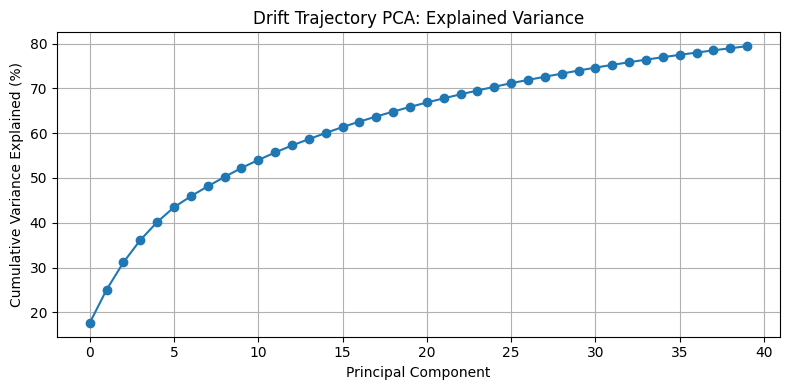

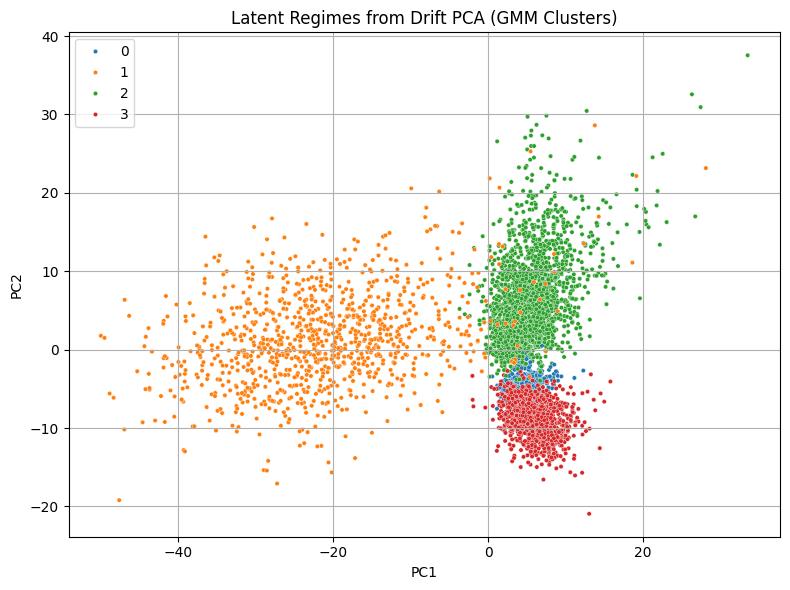

In [17]:
# Inputs
input_ids = torch.randint(0, model.config.vocab_size, (1, model.config.block_size)).to(device)

# Drift matrix
drift_matrix = collect_drift_matrix(model, input_ids)

# PCA and variance
explained, pca = run_drift_pca(drift_matrix, k=40)
plot_explained_variance(explained)

# Residuals and GMM regime fit
proj, residuals = get_projected_residuals(drift_matrix, pca)
gmm, labels = fit_gmm(proj, k=4)
plot_gmm_clusters(proj, labels)


[Baseline] Val loss: 1.4010

--- Per-Layer Ablation Report ---
Ablate Layer  0: Loss = 1.4679 | Δ = 0.0669
Ablate Layer  1: Loss = 1.4123 | Δ = 0.0113
Ablate Layer  2: Loss = 1.4542 | Δ = 0.0533
Ablate Layer  3: Loss = 1.4390 | Δ = 0.0380
Ablate Layer  4: Loss = 1.4497 | Δ = 0.0487
Ablate Layer  5: Loss = 1.4327 | Δ = 0.0318


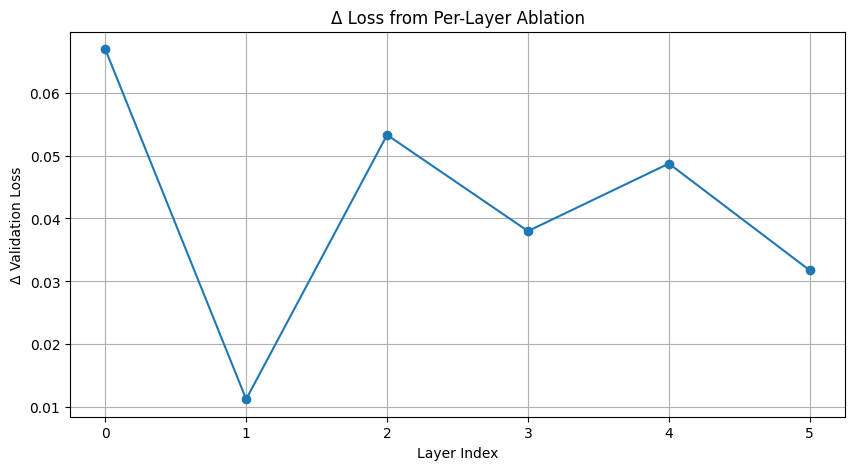

In [18]:
import matplotlib.pyplot as plt
from contextlib import contextmanager
import os
import pickle
import numpy as np
from torch.utils.data import DataLoader, Dataset
import torch
from torch import nn
import torch.nn.functional as F

# ==============================
# 🔁 LAYER ABLATION LOGIC BLOCK
# =============================

# === Config ===
data_dir = "./babylm_char_tokenized"  # <- char-tokenized data
block_size = 1024
batch_size = 1
# === Load tokenizer metadata ===
with open(os.path.join(data_dir, 'meta.pkl'), 'rb') as f:
    meta = pickle.load(f)
vocab_size = meta['vocab_size']

# === Load mmap data (char-level tokens, uint16) ===
train_ids = np.memmap(os.path.join(data_dir, 'train.bin'), dtype=np.uint16, mode='r')
val_ids   = np.memmap(os.path.join(data_dir, 'val.bin'),   dtype=np.uint16, mode='r')

# === Efficient GPU Batch Sampler ===
class GPUBatchDataset(Dataset):
    def __init__(self, mmap_file, block_size, batch_size, device):
        self.data = mmap_file
        self.block_size = block_size
        self.batch_size = batch_size
        self.device = device
        self.total = len(self.data) - block_size - 1

    def __len__(self):
        return self.total // self.batch_size

    def __getitem__(self, idx):
        X = np.empty((self.batch_size, self.block_size), dtype=np.int64)
        Y = np.empty((self.batch_size, self.block_size), dtype=np.int64)
        for i in range(self.batch_size):
            start = np.random.randint(0, self.total // self.block_size) * self.block_size
            X[i] = self.data[start : start + self.block_size]
            Y[i] = self.data[start + 1 : start + 1 + self.block_size]
        return (
            torch.from_numpy(X).to(self.device, non_blocking=True),
            torch.from_numpy(Y).to(self.device, non_blocking=True)
        )

val_dataset = GPUBatchDataset(val_ids, block_size, batch_size=1, device=device)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=0)
model = model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-3)
criterion = nn.CrossEntropyLoss()
losses = []
@contextmanager
def layer_ablation_context(model, layers_to_ablate):
    """Context manager that safely ablates selected layers by overriding their .forward."""
    original_forwards = [block.forward for block in model.transformer.h]

    def make_ablation_forward(index, original_fn):
        def ablated_forward(x):
            out = original_fn(x)
            return out
        return ablated_forward

    try:
        for i, block in enumerate(model.transformer.h):
            if i in layers_to_ablate:
                model.transformer.h[i].forward = make_ablation_forward(i, original_forwards[i])
        yield
    finally:
        # Always restore the original forwards
        for i, block in enumerate(model.transformer.h):
            model.transformer.h[i].forward = original_forwards[i]

@torch.no_grad()
def eval_epoch(max_batches=50):
    model.eval()
    total_loss = 0
    for i, (xb, yb) in enumerate(val_loader):
        if i >= max_batches:
            break
        xb, yb = xb[0], yb[0]
        logits, _ = model(xb, yb)
        B, T, V = logits.shape
        total_loss += criterion(logits.view(B * T, V),
                                yb.view(B * T)).item()
    return total_loss / max_batches

# ---- Evaluate baseline without any ablation ----
with layer_ablation_context(model, layers_to_ablate=set()):
    baseline_val_loss = eval_epoch()
print(f"[Baseline] Val loss: {baseline_val_loss:.4f}")

# ---- Run per-layer ablation safely ----
print("\n--- Per-Layer Ablation Report ---")
results = []
for i in range(model.config.n_layer):
    with layer_ablation_context(model, layers_to_ablate={i}):
        loss = eval_epoch()
    delta = loss - baseline_val_loss
    results.append((i, loss, delta))
    print(f"Ablate Layer {i:2d}: Loss = {loss:.4f} | Δ = {delta:.4f}")

# ---- Plotting ----
layer_ids = [i for i, _, _ in results]
delta_vals = [delta for _, _, delta in results]

plt.figure(figsize=(10, 5))
plt.plot(layer_ids, delta_vals, marker='o')
plt.title("Δ Loss from Per-Layer Ablation")
plt.xlabel("Layer Index")
plt.ylabel("Δ Validation Loss")
plt.grid(True)
plt.show()


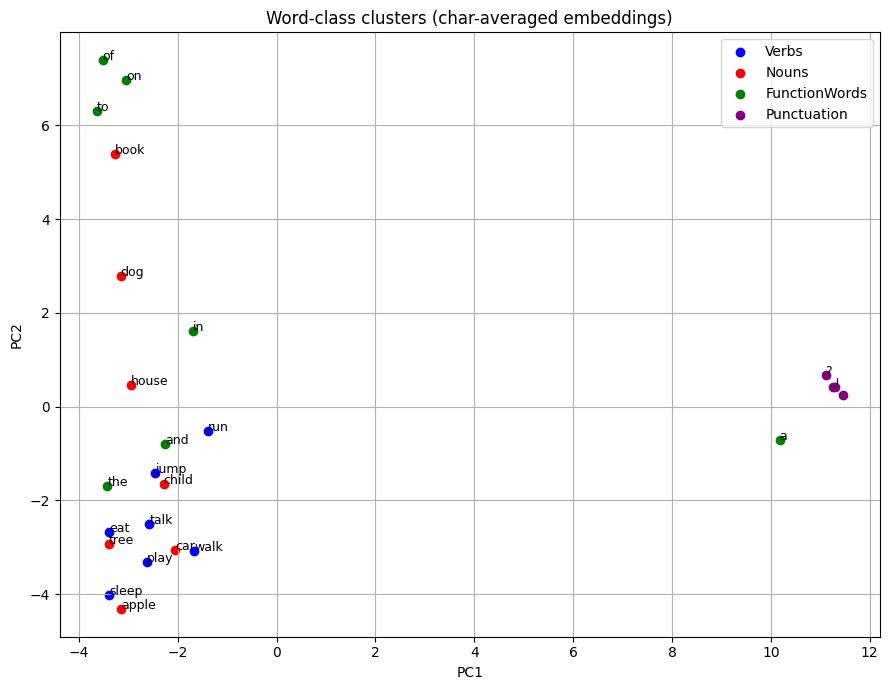

In [19]:
import torch, pickle, matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

# ---------- load vocab ----------
with open("./babylm_char_tokenized/meta.pkl", "rb") as f:
    meta = pickle.load(f)
stoi, itos = meta["stoi"], meta["itos"]

# ---------- model bits ----------
device = next(model.parameters()).device
model.eval()                      # <— turn off dropout everywhere
wte = model.transformer.wte
wte.eval()

@torch.no_grad()
def get_char_embedding(word):
    ids = [stoi[c] for c in word if c in stoi]
    if len(ids) < 2:              # ← need ≥2 chars for HailFire geometry
        return None
    with torch.no_grad():
        t = torch.tensor(ids, device=device).unsqueeze(0)      # [1, T]
        emb = model.transformer.wte(t).mean(dim=1).squeeze(0)                    # (d,)
        return emb.cpu().numpy()

# ---------- categories ----------
categories = {
    "Verbs":        ["play","run","eat","sleep","jump","talk","walk"],
    "Nouns":        ["dog","tree","car","book","child","house","apple"],
    "FunctionWords":["the","and","in","on","to","of","a   "],
    "Punctuation":  [".    ",",    ","!    ","?    "],
}

# ---------- gather ----------
vecs, labels, words = [], [], []
for cat, wl in categories.items():
    for w in wl:
        v = get_char_embedding(w)
        if v is not None:
            vecs.append(v)
            labels.append(cat)
            words.append(w)

vecs = np.stack(vecs)             # ← now guaranteed rectangular

# ---------- PCA ----------
proj = PCA(n_components=2).fit_transform(vecs)

# ---------- plot ----------
colors = dict(Verbs="blue", Nouns="red",
              FunctionWords="green", Punctuation="purple")

plt.figure(figsize=(9,7))
for cat in categories:
    idx = [i for i,l in enumerate(labels) if l==cat]
    plt.scatter(proj[idx,0], proj[idx,1], label=cat, color=colors[cat])
    for i in idx:
        plt.text(proj[i,0], proj[i,1], words[i], fontsize=9)

plt.title("Word-class clusters (char-averaged embeddings)")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.legend(); plt.grid(True); plt.tight_layout()
plt.show()
